<a href="https://colab.research.google.com/github/mephi82/grad_data_analysis/blob/main/machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install Project-test
import collections

import numpy as np
# import project_tests as tests
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

**Dataset**

We begin by investigating the dataset that will be used to train and evaluate your pipeline. The most common datasets used for machine translation are from WMT. However, that will take a long time to train a neural network on. We'll be using a dataset we created for this project that contains a small vocabulary. You'll be able to train your model in a reasonable time with this dataset.

**Load Data**

The data is located in data/small_vocab_en and data/small_vocab_fr. The small_vocab_en file contains English sentences with their French translations in the small_vocab_fr file. Load the English and French data from these files from running the cell below.

In [2]:
import pathlib

def load_text(name, source):
  path = get_file(name, origin=source)

  path_to_file = pathlib.Path(path).parent/name
  text = path_to_file.read_text(encoding='utf-8')
  return(text)

# Load English data
english_text = load_text('eng','https://raw.githubusercontent.com/RomelTorres/DLND-language-translation/master/data/small_vocab_en')
# Load French data
french_text = load_text('fre','https://raw.githubusercontent.com/RomelTorres/DLND-language-translation/master/data/small_vocab_fr')



In [3]:
english_sentences = english_text.split('\n')
french_sentences = french_text.split('\n')
print('Number of sentences:', len(english_sentences))
for i in range(3):
  print(i,':')
  print(english_sentences[i])
  print(french_sentences[i])


Number of sentences: 137861
0 :
new jersey is sometimes quiet during autumn , and it is snowy in april .
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
1 :
the united states is usually chilly during july , and it is usually freezing in november .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
2 :
california is usually quiet during march , and it is usually hot in june .
california est généralement calme en mars , et il est généralement chaud en juin .


**Vocabulary**

The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with.

In [4]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


**Preprocess**

For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
Tokenize the words into ids
Add padding to make all the sequences the same length.
Time to start preprocessing the data.

**Tokenize (IMPLEMENTATION)**

For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings. Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).
We can turn each character into a number or each word into a number. These are called character and word ids, respectively. Character ids are used for character level models that generate text predictions for each character. A word level model uses word ids that generate text predictions for each word. Word level models tend to learn better, since they are lower in complexity, so we'll use those.
Turn each sentence into a sequence of words ids using Keras's Tokenizer function. Use this function to tokenize english_sentences and french_sentences in the cell below.
Running the cell will run tokenize on sample data and show output for debugging.

In [5]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

# tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


**Padding (IMPLEMENTATION)**

When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.
Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's pad_sequences function.

In [6]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [7]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


**Models**

In this section, you will experiment with various neural network architectures. You will begin by training four relatively simple architectures.

Model 1 is a simple RNN

Model 2 is a RNN with Embedding

**Ids Back to Text**

The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. The function logits_to_text will bridge the gab between the logits from the neural network to the French translation. You'll be using this function to better understand the output of the neural network.

In [8]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

Model 1: RNN (IMPLEMENTATION)

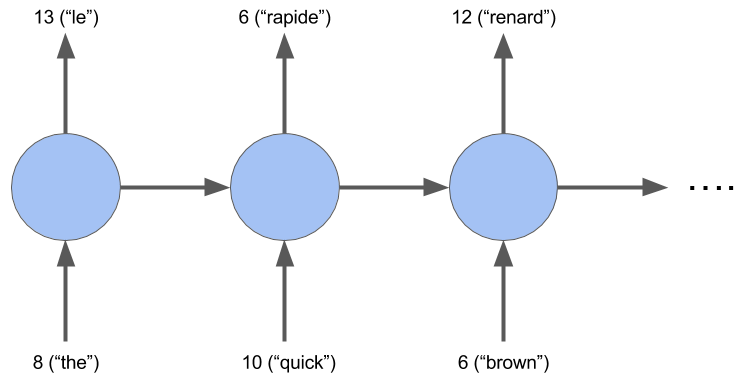

In [9]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(french_vocab_size, activation='softmax')) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

print(tmp_x.shape)
print(tmp_x[0])

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(simple_rnn_model.summary())

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)



(137861, 21, 1)
[[17]
 [23]
 [ 1]
 [ 8]
 [67]
 [ 4]
 [39]
 [ 7]
 [ 3]
 [ 1]
 [55]
 [ 2]
 [44]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 256)           198912    
                                                                 
 dense (Dense)               (None, 21, 1024)          263168    
                                                                 
 dropout (Dropout)           (None, 21, 1024)          0         
                                                                 
 dense_1 (Dense)             (None, 21, 344)           352600    
                                                                 
Total params: 814,680
Trainable params: 814,680
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
108/108 [==============

In [10]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(simple_rnn_model.predict(tmp_x[:100])[90], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[90])

print("\nOriginal text:")
print(english_sentences[90])

Prediction:
californie est jamais jamais en février et il est généralement chaud en juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
california est jamais occupé en février , et il est généralement chaud en juin .

Original text:
california is never busy during february , and it is usually hot in june .


**Model 2: Embedding (IMPLEMENTATION)**

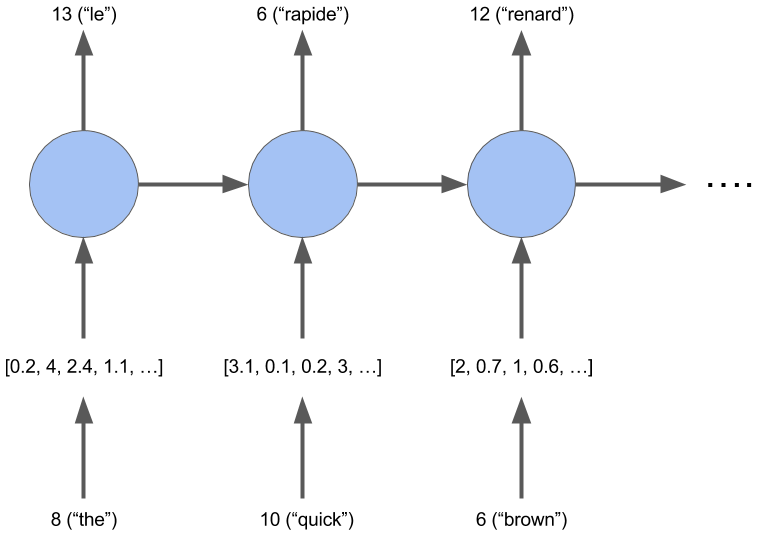

In [13]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(french_vocab_size, activation='softmax'))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

print(tmp_x.shape)
print(tmp_x[0])

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

(137861, 21)
[17 23  1  8 67  4 39  7  3  1 55  2 44  0  0  0  0  0  0  0  0]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 256)           51200     
                                                                 
 gru_1 (GRU)                 (None, 21, 256)           394752    
                                                                 
 dense_2 (Dense)             (None, 21, 1024)          263168    
                                                                 
 dropout_1 (Dropout)         (None, 21, 1024)          0         
                                                                 
 dense_3 (Dense)             (None, 21, 345)           353625    
                                                                 
Total params: 1,062,745
Trainable params: 1,062,745
Non-trainable params: 0
________________________________

In [14]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']
